In [93]:
# Подгружаем датасет: необходимо выбрать файл в диалоговом окне для дальнейшей работы ноутбука.
from google.colab import files
uploaded = files.upload()

In [94]:
# убеждаемся в наличии файла датасета
!ls

catboost_info  ebw_data.csv  sample_data


Подгружаем необходимые модули

In [95]:
#all imports and CONSTANTS
!pip install catboost # устанавливаем библиотеку CatBoost
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

RS = 120922
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загружаем датасет и проводим небольшой EDA

In [96]:
df = pd.read_csv('ebw_data.csv')

In [97]:
df.sample(5)

,IW,IF,VW,FP,Depth,Width
14,45,141,10.0,80,1.04,1.90
10,45,140,8.0,80,1.16,1.96
68,45,146,9.0,60,1.36,1.76
36,49,132,8.0,125,0.84,2.28
3,47,139,4.5,80,1.58,2.52


Посмотрим на пропуски

In [98]:
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

Пропусков не обнаружено

In [99]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


Явных выбросов в данных нет.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Все данные приведены к корректному типу.

Отобразим данные визуально

In [101]:
df.columns

Index(['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'], dtype='object')

In [102]:
X_columns = ['IW', 'IF', 'VW', 'FP'] # колонки с признаками

Cкатерплот и апроксимированная линейная зависимость для величины Depth:

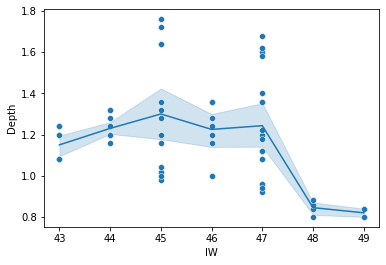

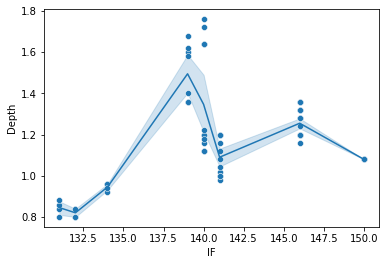

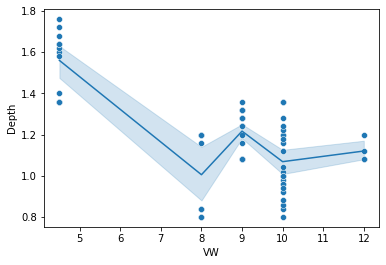

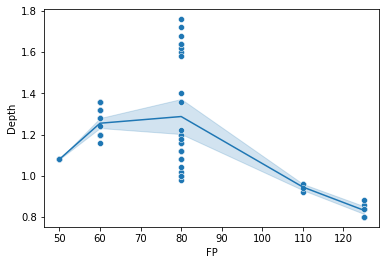

In [103]:
for X_column in X_columns:
  sns.lineplot(x=df[X_column], y=df['Depth'])
  sns.scatterplot(x=df[X_column], y=df['Depth'])
  plt.show()

Глянем на скатерплот и апроксимированную линейную зависимость для Width:

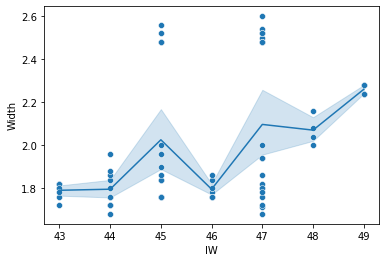

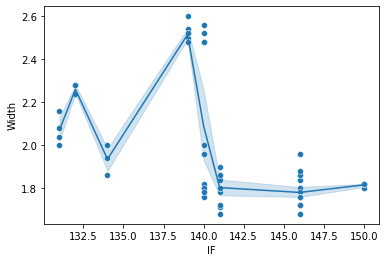

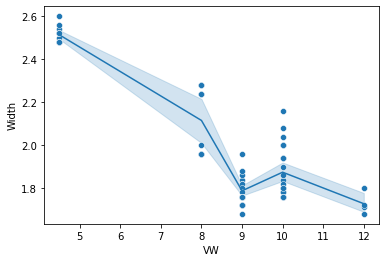

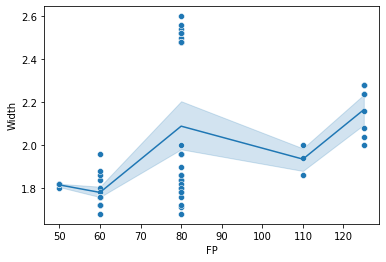

In [104]:
for X_column in X_columns:
  sns.lineplot(x=df[X_column], y=df['Width'])
  sns.scatterplot(x=df[X_column], y=df['Width'])
  plt.show()

Построение моделей и получение прогнозов искомых величин Depth и Width

Так как мы будем прогнозировать пару признаков, будем поэтапно предсказывать и рассчитывать ошибки модели для каждой из искомой величины. В качестве меры оценки ошибки модели выберем R2-score

Предсказываем признак Width
---

Разбиваем выборку на признаки и целевую переменную

In [105]:
X = df[X_columns]
y = df['Width']

Производим разделение тренировочной и тестовой выборки

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

Строим модель RandomForestRegressor + GridSearchCV:

Небольшая функция, которая будет выводить результаты модели

In [107]:
def get_resume(model, X_test_data):
  print('Наилучшие параметры модели: ', model.best_params_)
  print('Метрика точности модели на тренировочной выборке: ', model.best_score_)
  print('*'*20)
  print('Метрика точности модели на тестовой выборке: ', r2_score(y_test, model.predict(X_test_data)))
  print('*'*20)

In [108]:
%%time
param_grid = {'max_depth': [20],
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 7),
    'n_estimators': range(5, 15, 2)}

model = RandomForestRegressor(random_state=RS)
grid_rf = GridSearchCV(model, param_grid, cv=15, scoring='r2')
grid_rf.fit(X_train, y_train)

get_resume(grid_rf, X_test)

Наилучшие параметры модели:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 7}
Метрика точности модели на тренировочной выборке:  0.7787502652333631
********************
Метрика точности модели на тестовой выборке:  0.9456151460718925
********************
CPU times: user 19.2 s, sys: 153 ms, total: 19.3 s
Wall time: 24.8 s


Глянем, какие признаки модель RandomForest считает важными

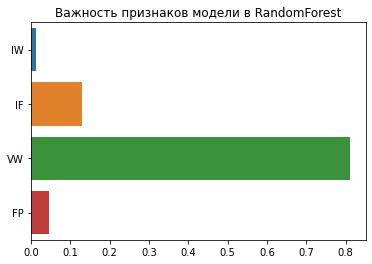

In [109]:
imp_feat = sns.barplot(x = grid_rf.best_estimator_.feature_importances_, y = X_columns )
imp_feat.set_title('Важность признаков модели в RandomForest')
plt.show()

Самым важным признаком модель посчитала VW - его вес около 0.8

Строим модель CatBoostRegressor + GridSearchCV:

In [110]:
%%time

param_grid = {'learning_rate': [0.01, 0.04, 0.1],
    'iterations': [2000],
    'l2_leaf_reg': range(10, 20, 3)}

model = CatBoostRegressor(random_state=RS, verbose=0)

grid_catboost = GridSearchCV(model, param_grid, cv=10, scoring='r2')
grid_catboost.fit(X_train, y_train)

get_resume(grid_catboost, X_test)

Наилучшие параметры модели:  {'iterations': 2000, 'l2_leaf_reg': 10, 'learning_rate': 0.01}
Метрика точности модели на тренировочной выборке:  0.9397690284795333
********************
Метрика точности модели на тестовой выборке:  0.9457547961563075
********************
CPU times: user 60 s, sys: 9.66 s, total: 1min 9s
Wall time: 39.9 s


Строим модель LinearRegression + PolynomialFeatures + GridSearchCV:

In [111]:
%%time

trans = PolynomialFeatures(degree=10)
lr = LinearRegression(normalize=True)

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

grid_lr = GridSearchCV(lr, parameters, cv=10)
grid_lr.fit(trans.fit_transform(X_train.to_numpy()), y_train)

get_resume(grid_lr, trans.fit_transform(X_test.to_numpy()))

Наилучшие параметры модели:  {'fit_intercept': False, 'normalize': True}
Метрика точности модели на тренировочной выборке:  0.932200637731504
********************
Метрика точности модели на тестовой выборке:  0.949942600609286
********************
CPU times: user 306 ms, sys: 192 ms, total: 498 ms
Wall time: 259 ms


In [112]:
X_columns

['IW', 'IF', 'VW', 'FP']

In [113]:
X_columns_wc = ['IW', 'IF', 'VW']
X = df[X_columns_wc]
y = df['Width']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

In [114]:
X_train.sample()

,IW,IF,VW
12,45,141,10.0


In [115]:
%%time

import warnings
warnings.filterwarnings('ignore')

trans = PolynomialFeatures(degree=10)
lr = LinearRegression(normalize=True)

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

grid_lr = GridSearchCV(lr, parameters, cv=10)
grid_lr.fit(trans.fit_transform(X_train.to_numpy()), y_train)

get_resume(grid_lr, trans.fit_transform(X_test.to_numpy()))

Наилучшие параметры модели:  {'fit_intercept': False, 'normalize': True}
Метрика точности модели на тренировочной выборке:  0.9262115412084004
********************
Метрика точности модели на тестовой выборке:  0.9499426006094285
********************
CPU times: user 190 ms, sys: 133 ms, total: 323 ms
Wall time: 181 ms


Предсказываем признак Depth
---

In [116]:
X = df[X_columns]
y = df['Depth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

модель RandomForestRegressor + GridSearchCV:

In [117]:
%%time
param_grid = {
    'max_depth': [20],
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 7),
    'n_estimators': range(5, 15 , 2)
}

model = RandomForestRegressor(random_state=RS)

grid_rf = GridSearchCV(model, param_grid, cv=15, scoring='r2')
grid_rf.fit(X_train, y_train)

get_resume(grid_rf, X_test)

Наилучшие параметры модели:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 5}
Метрика точности модели на тренировочной выборке:  0.6478832354695022
********************
Метрика точности модели на тестовой выборке:  0.9034824453866852
********************
CPU times: user 26.7 s, sys: 246 ms, total: 26.9 s
Wall time: 26.8 s


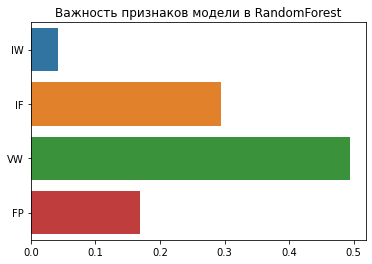

In [118]:
imp_feat = sns.barplot(x = grid_rf.best_estimator_.feature_importances_, y = X_columns )
imp_feat.set_title('Важность признаков модели в RandomForest')
plt.show()

модель CatBoostRegressor + GridSearchCV:

In [119]:
%%time

param_grid = {
    'learning_rate': [0.01, 0.04, 0.1],
    'iterations': [2000],
    'l2_leaf_reg': range(10, 20, 3),
    }

model = CatBoostRegressor(random_state=RS, verbose=0)

grid_catboost = GridSearchCV(model, param_grid, cv=20, scoring='r2')
grid_catboost.fit(X_train, y_train)

get_resume(grid_catboost, X_test)

Наилучшие параметры модели:  {'iterations': 2000, 'l2_leaf_reg': 13, 'learning_rate': 0.1}
Метрика точности модели на тренировочной выборке:  -0.6269691255354108
********************
Метрика точности модели на тестовой выборке:  0.8717090530507986
********************
CPU times: user 2min, sys: 18.8 s, total: 2min 19s
Wall time: 1min 20s


модель LinearRegression + PolynomialFeatures + GridSearchCV:

In [120]:
%%time

import warnings
warnings.filterwarnings('ignore')

trans = PolynomialFeatures(degree=10)
lr = LinearRegression(normalize=True)

parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

grid_lr = GridSearchCV(lr, parameters, cv=10)
grid_lr.fit(trans.fit_transform(X_train.to_numpy()), y_train)

get_resume(grid_lr, trans.fit_transform(X_test.to_numpy()))

Наилучшие параметры модели:  {'fit_intercept': False, 'normalize': True}
Метрика точности модели на тренировочной выборке:  0.8228038761540006
********************
Метрика точности модели на тестовой выборке:  0.8717090869410888
********************
CPU times: user 325 ms, sys: 207 ms, total: 532 ms
Wall time: 281 ms


Постороены 3 модели CatBoost, RandomForest, LinearRegression. Модели показали неплохие результаты по оценкам скоринга R2. Обучение и оценка моделей осложняется очень маленьким датасетом. Из трех моделей стоит отметить LinearRegression - модель легковесная, быстро обучается, имеет результаты схожие с тяжелыми моделями, кроме того данная модель будет обладать лучшими обобщающими способностями.